In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import lightning as L
from torchmetrics import Accuracy
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLASSES = len(CLASSES)

cuda:0


In [ ]:
# If you run into memory issues, you can reduce the batch size
BATCH_SIZE = 128

# Change these to the relative paths you'd like to use
# for the CIFAR-10 data and model checkpoints
DATA_PATH = 'data/'
CHECKPOINT_PATH = 'models/checkpoints/'

# The different models we'll be fine-tuning
SAVE_NAMES = [
    'baseline',
    'adv_train',    # Adversarial training a la Madry et al.
    'SAP_conv', # Full SAP post-convolution a la Dhillon et al.
]
SAVE_NAMES = {
    name: os.path.join(CHECKPOINT_PATH, name) for name in SAVE_NAMES
}

# Results dictionary


In [ ]:
models = {name: None for name in SAVE_NAMES.keys()}
attacks = {
    'id': None,
    'fgsm': None,
    'pgd': None,
}

results_dic = {
    'model': [],
    'attack': [],
    'top_k': [],
    'accuracy': [],
}
results_trainer = L.Trainer(accelerator='auto', devices=1)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Data processing

In [ ]:
# Pretrained normalization based on https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
means, stds = [0.49139968, 0.48215827, 0.44653124], [0.24703233, 0.24348505, 0.26158768]
means, stds = np.array(means), np.array(stds)

In [ ]:
import torchvision.transforms.v2 as transforms

def get_cifar_loaders(batch_size):
    # Transformations applied to images before passing them to the model
    transform = transforms.Compose(
        [
            # transforms.Resize(256),
            # transforms.CenterCrop(224),
            transforms.ToImage(), # Converts to tensor
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=means, std=stds)
        ])

    trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,
                                            download=True, transform=transform)
    # The train set is of size 50000
    trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    return trainloader, valloader, testloader

In [ ]:
trainloader, valloader, testloader = get_cifar_loaders(BATCH_SIZE)
sample_images, sample_labels = next(iter(trainloader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

100%|██████████| 170498071/170498071 [00:12<00:00, 13327909.04it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


# Base Resnet Class
Here I've implemented a ResNet18 model in the Pytorch Lightning framework.

In [ ]:
class LResnet(L.LightningModule):
    def __init__(self, adv_train_method = None): #EDITED
        super().__init__()
        # Set loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        # CIFAR-10 images are 32x32
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)
        self.num_target_classes = 10
        # Accuracy metric for training logs and testing evaluation
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_target_classes, top_k=1)
        # Adversarial generation method for training
        self.adv_train_method = adv_train_method # EDITED

        # Load pretrained model weights
        self.model = torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        )
        # Change final layer from 1000 (ImageNet) classes to 10 (CIFAR-10) classes
        self.model.fc = nn.Linear(self.model.fc.in_features, self.num_target_classes)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-5, weight_decay=0.1)
        return [optimizer] # Lightning has enables multi-optimizer training, e.g. for GANs

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        if self.adv_train_method is not None:
            opt = self.optimizers()
            opt.zero_grad()
            # Change the images to adversarial examples
            imgs = self.adv_train_method(self.model, imgs, labels)
            # adv_train_method sets the model to eval
            self.model.train()
            # Reset accumulated gradients from adversarial generation
            opt.zero_grad()
        # Once we have the correct training images,
        # we can use the usual Lightning forward pass
        outputs = self.model(imgs)
        loss = self.loss_module(outputs, labels)
        acc = self.accuracy(outputs, labels)
        # Log accuracy and loss per-batch for Tensorboard
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        outputs = self.model(imgs)
        loss = self.loss_module(outputs, labels)
        self.log('val_loss', loss)
        # No need to return to call backward() on the loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        outputs = self.model(imgs)
        acc = self.accuracy(outputs, labels)
        self.log("test_acc", acc, prog_bar=True)
        # No need to return to call backward() on the loss

## Example training code

In [ ]:
save_key = 'baseline'
baseline_model = LResnet()
baseline_trainer = L.Trainer(
    default_root_dir = SAVE_NAMES[save_key], # Where to save the model
    accelerator='auto',
    devices=1,
    max_epochs=30,
    callbacks=[
        ModelCheckpoint( # Save the best model by validation loss
            dirpath=SAVE_NAMES[save_key],
            monitor='val_loss',
            save_top_k=1,
            mode='min',
            save_weights_only=True,
            every_n_epochs=1,
        ),
        EarlyStopping( # Stop training early if val_loss doesn't improve
            monitor='val_loss',
            patience=3,
            verbose=True,
            mode='min',
        ),
        LearningRateMonitor('epoch') # Log learning rate each epoch
    ],
)

# These two lines are optional, but they make the Tensorboard logs look nicer
baseline_trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
baseline_trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

# This is all you need to train the model
baseline_trainer.fit(baseline_model, trainloader, valloader)
# Load best checkpoint after training
baseline_model = LResnet.load_from_checkpoint(
    baseline_trainer.checkpoint_callback.best_model_path
).to(device)

# Store the model in the dictionary
models[save_key] = baseline_model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA devi

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 1.577
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 1.577


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.364 >= min_delta = 0.0. New best score: 1.213
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.364 >= min_delta = 0.0. New best score: 1.213


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 1.042
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 1.042


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 0.946
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 0.946


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.886
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.886


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.846
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.846


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.820
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.820


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.797
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.797


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.785
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.785


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.777
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.777


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.774
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.774


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 3 records. Best score: 0.774. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.774. Signaling Trainer to stop.


cuda:0


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type               | Params | Mode  | In sizes       | Out sizes
----------------------------------------------------------------------------------------
0 | loss_module | CrossEntropyLoss   | 0      | train | ?              | ?        
1 | accuracy    | MulticlassAccuracy | 0      | train | ?              | ?        
2 | model       | ResNet             | 11.2 M | train | [1, 3, 32, 32] | [1, 10]  
--------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 1.550
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 1.550


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.342 >= min_delta = 0.0. New best score: 1.208
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.342 >= min_delta = 0.0. New best score: 1.208


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.157 >= min_delta = 0.0. New best score: 1.051
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.157 >= min_delta = 0.0. New best score: 1.051


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 0.956
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 0.956


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.895
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.895


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.855
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.855


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.825
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.825


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.807
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.807


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.794
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.794


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.787
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.787


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 3 records. Best score: 0.787. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.787. Signaling Trainer to stop.


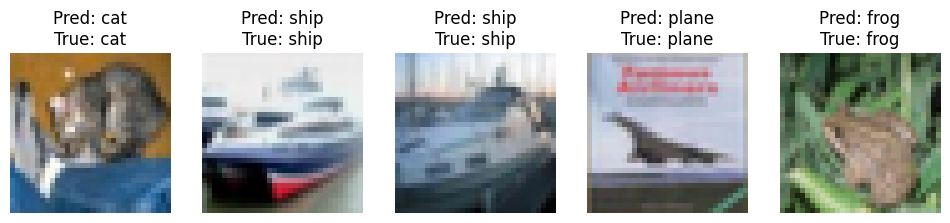

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import lightning as L
from torchmetrics import Accuracy
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping

# Define device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# Define classes and other constants
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 128
DATA_PATH = 'data/'
CHECKPOINT_PATH = 'models/checkpoints/'

SAVE_NAMES = [
    'baseline',
    'adv_train',    # Adversarial training a la Madry et al.
    'SAP_conv', # Full SAP post-convolution a la Dhillon et al.
]
SAVE_NAMES = {name: os.path.join(CHECKPOINT_PATH, name) for name in SAVE_NAMES}

# Results dictionary
models = {name: None for name in SAVE_NAMES.keys()}
attacks = {
    'id': None,
    'fgsm': None,
    'pgd': None,
}
results_dic = {
    'model': [],
    'attack': [],
    'top_k': [],
    'accuracy': [],
}
results_trainer = L.Trainer(accelerator='auto', devices=1)

# Data processing
means, stds = [0.49139968, 0.48215827, 0.44653124], [0.24703233, 0.24348505, 0.26158768]
means, stds = np.array(means), np.array(stds)
import torchvision.transforms.v2 as transforms

def get_cifar_loaders(batch_size):
    transform = transforms.Compose(
        [
            transforms.ToImage(), # Converts to tensor
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=means, std=stds)
        ])

    trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,
                                            download=True, transform=transform)
    trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    return trainloader, valloader, testloader

trainloader, valloader, testloader = get_cifar_loaders(BATCH_SIZE)
sample_images, sample_labels = next(iter(trainloader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

# Base Resnet Class
class LResnet(L.LightningModule):
    def __init__(self, adv_train_method=None):
        super().__init__()
        self.loss_module = nn.CrossEntropyLoss()
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)
        self.num_target_classes = 10
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_target_classes, top_k=1)
        self.adv_train_method = adv_train_method

        self.model = torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        )
        self.model.fc = nn.Linear(self.model.fc.in_features, self.num_target_classes)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-5, weight_decay=0.1)
        return [optimizer]

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        if self.adv_train_method is not None:
            opt = self.optimizers()
            opt.zero_grad()
            imgs = self.adv_train_method(self.model, imgs, labels)
            self.model.train()
            opt.zero_grad()
        outputs = self.model(imgs)
        loss = self.loss_module(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        outputs = self.model(imgs)
        loss = self.loss_module(outputs, labels)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        outputs = self.model(imgs)
        acc = self.accuracy(outputs, labels)
        self.log("test_acc", acc, prog_bar=True)

# Training code
save_key = 'baseline'
baseline_model = LResnet()
baseline_trainer = L.Trainer(
    default_root_dir=SAVE_NAMES[save_key],
    accelerator='auto',
    devices=1,
    max_epochs=30,
    callbacks=[
        ModelCheckpoint(
            dirpath=SAVE_NAMES[save_key],
            monitor='val_loss',
            save_top_k=1,
            mode='min',
            save_weights_only=True,
            every_n_epochs=1,
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=True,
            mode='min',
        ),
        LearningRateMonitor('epoch')
    ],
)

baseline_trainer.logger._log_graph = True
baseline_trainer.logger._default_hp_metric = None
baseline_trainer.fit(baseline_model, trainloader, valloader)

baseline_model = LResnet.load_from_checkpoint(
    baseline_trainer.checkpoint_callback.best_model_path
).to(device)

models[save_key] = baseline_model

# Visualization function
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for idx in range(num_images):
        ax = plt.subplot(1, num_images, idx + 1)
        plt.imshow(np.transpose(images[idx].cpu().numpy(), (1, 2, 0)) * stds + means)
        plt.title(f"Pred: {CLASSES[preds[idx]]}\nTrue: {CLASSES[labels[idx]]}")
        plt.axis("off")
    plt.show()

# Visualize predictions
visualize_predictions(baseline_model, testloader, num_images=5)


# Adversarial attacks
FGSM + PGD

In [ ]:
# Used as a baseline
def id(model, imgs, labels):
    return imgs.detach()

def fgsm(model, imgs, labels, device=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")):
    r"""
    Args:
        model (nn.Module): Model to attack, e.g. self.model in the LResnet definition.
        imgs (Tensor): Tensor of images. Size (BATCH_SIZE, C, H, W). Normalized according to means, stds.
        labels (Tensor): Tensor of labels. Size (BATCH_SIZE,). Each element is an integer in [0, NUM_CLASSES).
    Returns:
        adv_imgs (Tensor): Adversarial images. Same dimensions and normalization as imgs. Detached.
            Each adversarial image in the batch is L_infinity distance at most eps away from the original image.
            Images generated by the Fast Gradient Sign Method (FGSM).
    """
    eps = 8/255 # Maximum perturbation
    model.eval()
    model.to(device)
    imgs = imgs.to(device)
    labels = labels.to(device)

    imgs.requires_grad = True
    outputs = model(imgs)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()
    imgs.requires_grad = True
    adv_imgs = imgs + eps * imgs.grad.sign()
    adv_imgs = torch.clamp(adv_imgs, 0, 1).detach()  # Ensure pixel values are valid and detach from the graph
    return adv_imgs


def pgd(model, imgs, labels):
    r"""
    Args:
        model (nn.Module): Model to attack, e.g. self.model in the LResnet definition.
        imgs (Tensor): Tensor of images. Size (BATCH_SIZE, C, H, W). Normalized according to means, stds.
        labels (Tensor): Tensor of labels. Size (BATCH_SIZE,). Each element is an integer in [0, NUM_CLASSES).
    Returns:
        adv_imgs (Tensor): Adversarial images. Same dimensions and normalization as imgs. Detached.
            Each adversarial image in the batch is L_infinity distance at most eps away from the original image.
            Images generated by the Projected Gradient Descent (PGD)
    """
    iters = 20 # Number of steps in PGD
    eps = 8/255 # Maximum perturbation
    alpha = 2/255 # Step size
    adv_imgs = imgs.clone().detach()  # Start with the original images
    adv_imgs = adv_imgs + torch.randn_like(adv_imgs) * eps  # Add initial random perturbation
    adv_imgs = torch.clamp(adv_imgs, 0, 1)  # Ensure still in image range

    for _ in range(iters):
        adv_imgs.requires_grad = True
        outputs = model(adv_imgs)
        model.zero_grad()
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        with torch.no_grad():
            # Apply perturbation
            adv_imgs = adv_imgs + alpha * adv_imgs.grad.sign()
            # Project back into the epsilon-ball around original image
            delta = torch.clamp(adv_imgs - imgs, min=-eps, max=eps)
            adv_imgs = torch.clamp(imgs + delta, min=0, max=1)

    return adv_imgs.detach()


attacks['id'] = id
attacks['fgsm'] = fgsm
attacks['pgd'] = pgd

# Adversarial Defenses

## Adversarial Training
Implemented the training loop for an adversarially trained model using PGD as the adversarial example generation method.

In [ ]:
save_key = 'adv_train'
adv_train_model = LResnet(adv_train_method=pgd)

adv_trainer = L.Trainer(
    default_root_dir=SAVE_NAMES[save_key],
    accelerator='auto',
    devices=1,
    max_epochs=30,
    callbacks=[
        ModelCheckpoint(
            dirpath=SAVE_NAMES[save_key],
            monitor='val_loss',
            save_top_k=1,
            mode='min',
            save_weights_only=True,
            every_n_epochs=1,
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=True,
            mode='min',
        ),
        LearningRateMonitor('epoch')
    ],
)

adv_trainer.fit(adv_train_model, trainloader, valloader)

# Load best checkpoint after training
adv_train_model = LResnet.load_from_checkpoint(
    adv_trainer.checkpoint_callback.best_model_path
).to(device)

# Store the model in the dictionary
models[save_key] = adv_train_model


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /content/models/checkpoints/adv_train exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type               | Params | Mode  | In sizes       | Out sizes
----------------------------------------------------------------------------------------
0 | loss_module | CrossEntropyLoss   | 0      | train | ?              | ?        
1 | accuracy    | MulticlassAccuracy | 0      | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 4.645
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 4.645


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.907 >= min_delta = 0.0. New best score: 3.738
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.907 >= min_delta = 0.0. New best score: 3.738


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.879 >= min_delta = 0.0. New best score: 2.859
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.879 >= min_delta = 0.0. New best score: 2.859


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.220 >= min_delta = 0.0. New best score: 2.640
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.220 >= min_delta = 0.0. New best score: 2.640


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 2.525
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 2.525


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.364 >= min_delta = 0.0. New best score: 2.160
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.364 >= min_delta = 0.0. New best score: 2.160


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 3 records. Best score: 2.160. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 2.160. Signaling Trainer to stop.


## SAP
### Function implementation
Implemented a function that applies [Stochastic Activation Pruning](https://arxiv.org/pdf/1803.01442.pdf) (SAP) to a Tensor.

In [ ]:
def sap(act):
    r"""
    Args:
        act (Tensor): Tensor of activations of shape (K, C, H, W), where K is the batch size.
        The values of C, H, W depend on the layer.
    Returns:
        Tensor of the same shape as act, masked and rescaled according to the SAP method.
    """
    N = act.numel() / act.shape[0]  # Total number of entries per example in the batch
    abs_act = act.abs()

    # Compute probabilities proportional to the absolute value of activations, normalized
    p = abs_act / abs_act.view(act.shape[0], -1).sum(dim=1, keepdim=True).view(act.shape[0], 1, 1, 1)

    # Compute the probability of keeping each entry
    q = 1 - torch.exp(-2 * N * p)

    # Generate the mask: draw random values and compare to q
    random_vals = torch.rand_like(act)
    mask = (random_vals < q).float()

    # Apply the mask and normalize
    pruned_act = act * mask / q.clamp(min=1e-5)  # Clamp q to avoid division by zero

    return pruned_act

### Adjusted Model


In [ ]:
class SAP_Conv2d(nn.Conv2d):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride=1,
            padding=0,
            groups=1,
            bias=True,
            dilation=1,
    ):
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, dilation, groups, bias)

    # This is the important part
    def _conv_forward(self, input, weight, bias):
        act = super()._conv_forward(input, weight, bias)
        masked_act = sap(act)
        return masked_act

In [ ]:
def to_sap_conv(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            sap_conv = SAP_Conv2d(
                in_channels=module.in_channels,
                out_channels=module.out_channels,
                kernel_size=module.kernel_size,
                stride=module.stride,
                padding=module.padding,
                dilation=module.dilation,
                groups=module.groups,
                bias=(module.bias is not None)
            )

            sap_conv.weight.data = module.weight.data.clone()
            if module.bias is not None:
                sap_conv.bias.data = module.bias.data.clone()

            model._modules[name] = sap_conv
        else:
            to_sap_conv(module)



In [ ]:
sap_conv_model = LResnet()
to_sap_conv(sap_conv_model)

for module in sap_conv_model.modules():
    if isinstance(module, nn.Conv2d):
        print("Found a nn.Conv2d layer that was not replaced.")
        break
else:
    print("All nn.Conv2d layers have been replaced.")


Found a nn.Conv2d layer that was not replaced.


In [ ]:
sap_conv_model = LResnet()
to_sap_conv(sap_conv_model)
for module in sap_conv_model.modules():
    print(module)

LResnet(
  (loss_module): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
  (model): ResNet(
    (conv1): SAP_Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): SAP_Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): SAP_Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): SAP_Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

### Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sap_conv_model = LResnet().to(device)
to_sap_conv(sap_conv_model)



save_key = 'SAP_conv'
sap_trainer = L.Trainer(
    default_root_dir=SAVE_NAMES[save_key],  # Use the SAP_conv save key
    accelerator='auto',
    devices=1,
    max_epochs=50,  # Adjust as necessary
    callbacks=[
        ModelCheckpoint(
            dirpath=SAVE_NAMES[save_key],
            monitor='val_loss',
            save_top_k=1,
            mode='min',
            save_weights_only=True,
            every_n_epochs=1,
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=True,
            mode='min',
        ),
        LearningRateMonitor('epoch'),
    ],
)

# Fit the model using the train and validation data loaders
sap_trainer.fit(sap_conv_model, trainloader, valloader)

best_sap_conv_model = LResnet.load_from_checkpoint(
    sap_trainer.checkpoint_callback.best_model_path
)

best_sap_conv_model = best_sap_conv_model.to(device)



# Store the model in the dictionary
models[save_key] = best_sap_conv_model

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /content/models/checkpoints/SAP_conv exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type               | Params | Mode  | In sizes       | Out sizes
----------------------------------------------------------------------------------------
0 | loss_module | CrossEntropyLoss   | 0      | train | ?              | ?        
1 | accuracy    | MulticlassAccuracy | 0      | trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2.022
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.022


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.277 >= min_delta = 0.0. New best score: 1.745
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.277 >= min_delta = 0.0. New best score: 1.745


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.148 >= min_delta = 0.0. New best score: 1.596
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.148 >= min_delta = 0.0. New best score: 1.596


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 1.477
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 1.477


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 1.394
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 1.394


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.345
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.345


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.282
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.282


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.231
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.231


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.180
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.180


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.151
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.151


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.122
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.122


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.079
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.079


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.049
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.049


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.031
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.031


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.993
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.985
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.985


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.954
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.954


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.947
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.947


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.921
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.921


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.916
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.916


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.893
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.893


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.880
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.880


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.865
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.865


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.862
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.862


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.853
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.853


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.836
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.836


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.818
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.818


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.811
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.811


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.804
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.804


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.790
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.790


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.790
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.790


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.788
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.788


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.772
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.772


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.768
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.768


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.765
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.765


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.751
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.751


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.749
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.749


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.745
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.745


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.738
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.738


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 3 records. Best score: 0.738. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.738. Signaling Trainer to stop.


In [ ]:
offset = 97

In [ ]:
def visualize_predictions(model, dataloader, num_images=8):
    model.eval()
    model.to(device)
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for idx in range(num_images):
        ax = plt.subplot(1, num_images, idx + 1)
        plt.imshow(np.transpose(images[idx+offset].cpu().numpy(), (1, 2, 0)) * 2 * stds + means)
        plt.title(f"Pred: {CLASSES[preds[idx+offset]]}\nTrue: {CLASSES[labels[idx+offset]]}")
        plt.axis("off")
    plt.show()

def test_pgd_examples(model, dataloader, num_images=5):
    model.eval()
    model.to(device)
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd(model, images, labels)
    outputs = model(adv_images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for idx in range(num_images):
        ax = plt.subplot(1, num_images, idx + 1)
        plt.imshow(np.transpose(adv_images[idx+offset].cpu().numpy(), (1, 2, 0)) * 2 * stds + means)
        plt.title(f"Pred: {CLASSES[preds[idx+offset]]}\nTrue: {CLASSES[labels[idx+offset]]}")
        plt.axis("off")
    plt.show()

def visualize_fgsm_examples(model, dataloader, num_images=5):
    model.eval()
    model.to(device)
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    adv_images = fgsm(model, images, labels)
    outputs = model(adv_images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for idx in range(num_images):
        ax = plt.subplot(1, num_images, idx + 1)
        plt.imshow(np.transpose(adv_images[idx+offset].cpu().numpy(), (1, 2, 0)) * 2* stds + means)
        plt.title(f"Pred: {CLASSES[preds[idx+offset]]}\nTrue: {CLASSES[labels[idx+offset]]}")
        plt.axis("off")
    plt.show()

# Baseline

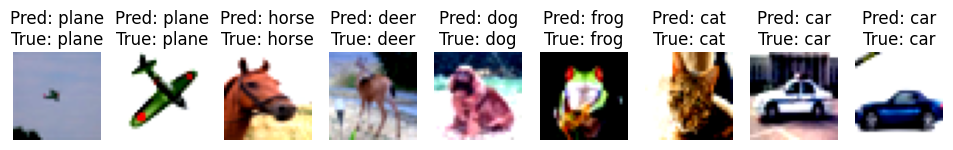

In [ ]:
visualize_predictions(baseline_model, testloader, num_images=9)

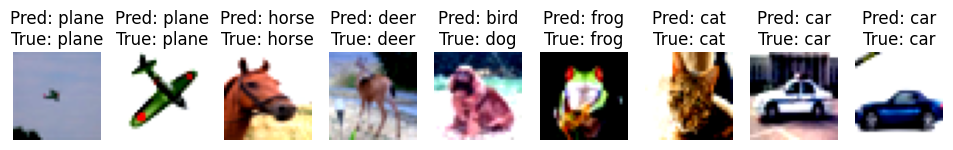

In [ ]:
visualize_predictions(sap_conv_model, testloader, num_images=9)

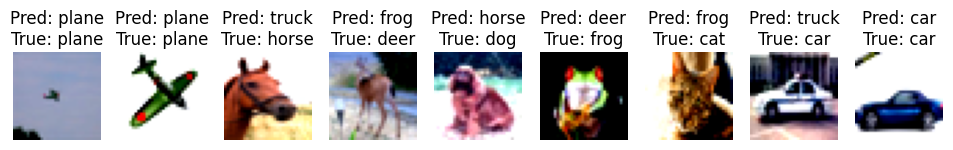

In [ ]:
visualize_predictions(adv_train_model, testloader, num_images=9)

# PGD Perturbations ------------------------------------------------------------------------------

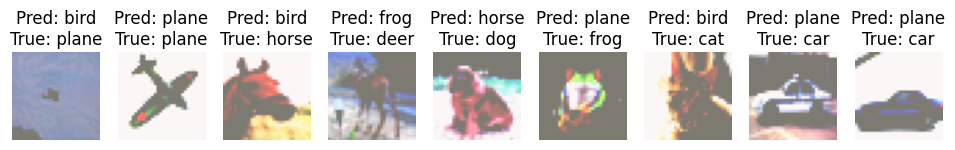

In [ ]:
test_pgd_examples(baseline_model, testloader, num_images=9)

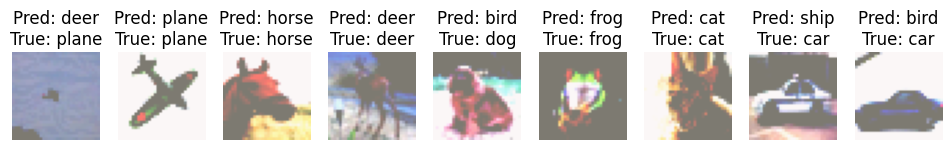

In [ ]:
test_pgd_examples(sap_conv_model, testloader, num_images=9)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


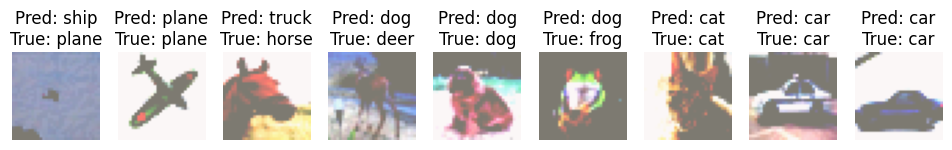

In [ ]:
test_pgd_examples(adv_train_model, testloader, num_images=9)

#FGSM perturbations ------------------------------------------------------------------------------

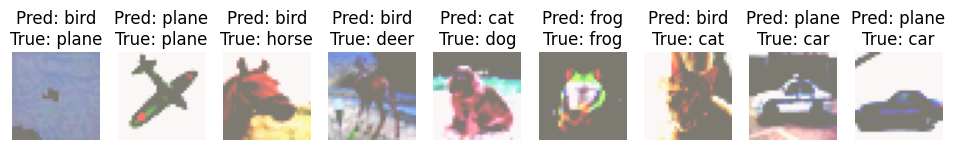

In [ ]:
visualize_fgsm_examples(baseline_model, testloader, num_images=9)

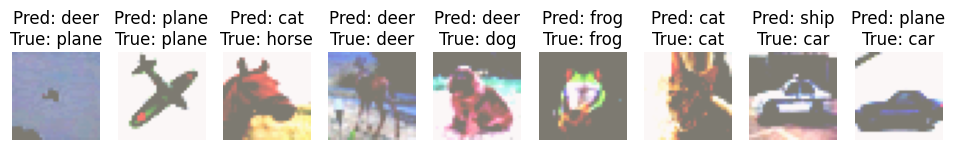

In [ ]:
visualize_fgsm_examples(sap_conv_model, testloader, num_images=9)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


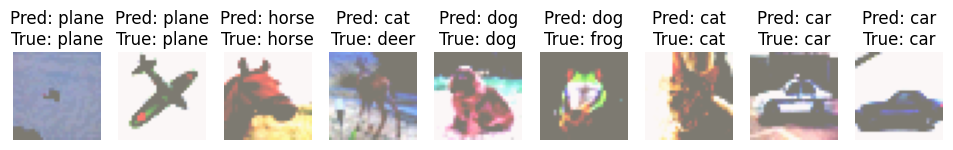

In [ ]:
visualize_fgsm_examples(adv_train_model, testloader, num_images=9)

# Evaluation

## Methods
These two functions help us modularize the experiments we run. Complete ```eval_attack``` to compute the accuracy of each model (baseline, adversarially trained, SAP) on images. We take every batch in ```loader```, apply ```attack_method``` to the batch, and check the accuracy of ```model``` in predicting the class of each adversarial image. Output a Float between 0 and 1.

```top_k``` describes how we determine accuracy. For example, ```top_k=2``` means if the model predicts the correct class within its two highest-scoring classes, it's counted as correct.

Complete the next code block and just run the one after that.

In [ ]:
def eval_attack(model, attack_method, loader, top_k, max_batches=0):
    r"""
    Args:
        model (LResnet): Model to attack.
        attack_method (function): Adversarial generation method. One of id, fgsm, pgd.
        loader (DataLoader): Data loader for the dataset to evaluate on.
        top_k (int): The number of top predictions to check for correctness.
        max_batches (int): Maximum number of batches to evaluate. If 0, evaluate on the entire dataloader.
    Returns:
        float: Accuracy of the model on the (adversarially perturbed) dataset.
    """
    # YOUR CODE HERE
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(loader):
        if max_batches and batch_idx >= max_batches:
            break  # Stop evaluation if max_batches is reached

        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        adv_images = attack_method(model, images, labels)  # Generate adversarial examples

        outputs = model(adv_images)  # Get model predictions for adversarial images
        _, pred = outputs.topk(top_k, 1, True, True)
        pred = pred.t()
        correct += pred.eq(labels.view(1, -1).expand_as(pred)).sum().item()

        total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [ ]:
def run_experiment(model, attack, top_k=2, max_batches=0):
    # If we're re-running an experiment, remove the old results
    for i in range(len(results_dic['model'])):
        if results_dic['model'][i] == model and results_dic['attack'][i] == attack and results_dic['top_k'][i] == top_k:
            results_dic['model'].pop(i)
            results_dic['attack'].pop(i)
            results_dic['top_k'].pop(i)
            results_dic['accuracy'].pop(i)
            break
    # Run the experiment
    acc = eval_attack(
        models[model],
        attacks[attack],
        testloader,
        top_k=top_k,
        max_batches=max_batches
    )
    # Store the results
    results_dic['model'].append(model)
    results_dic['attack'].append(attack)
    results_dic['top_k'].append(top_k)
    results_dic['accuracy'].append(acc)

## Experiments

In [ ]:
torch.set_grad_enabled(True)
torch.autograd.set_detect_anomaly(True)

### Display results
We've already stored the results in a dictionary. Let's put them in a Pandas DataFrame to make them nicer to look at. Export your results to a CSV to save them.

It might take some manual work, but if you run any training loop more than once you should probably keep track, e.g. in a spreadsheet or in file names, of which one is which. In particular, always ensure you will know which model is the most recently trained: even better, ensure you'll still know in a month or more.

### Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir=models/checkpoints/

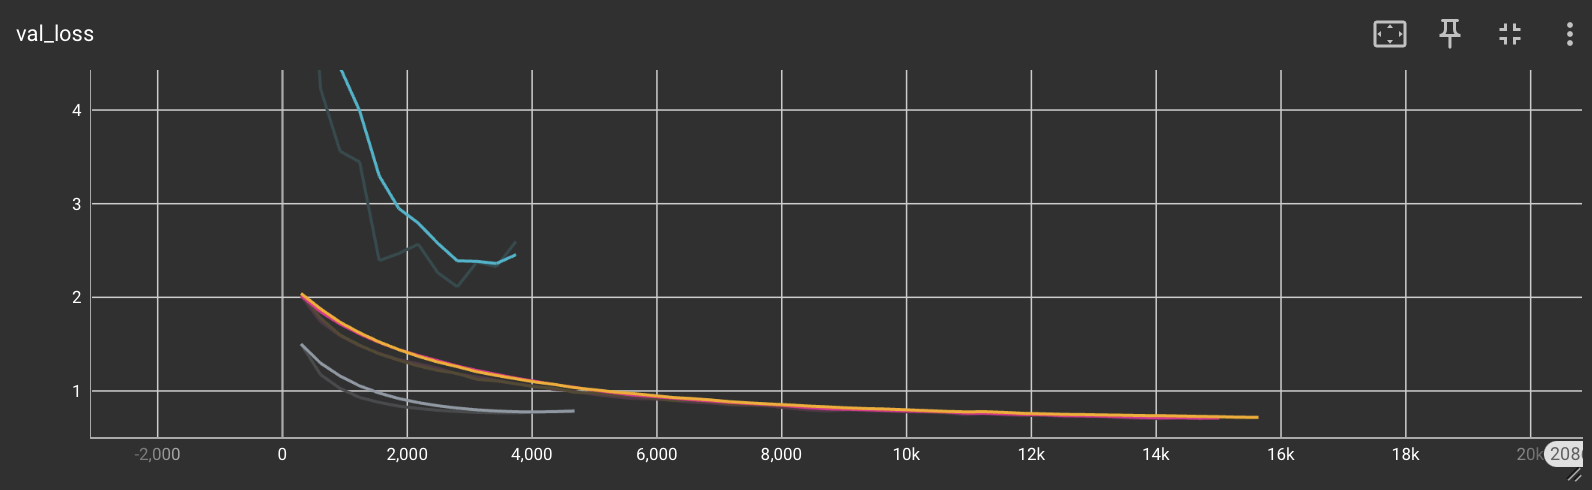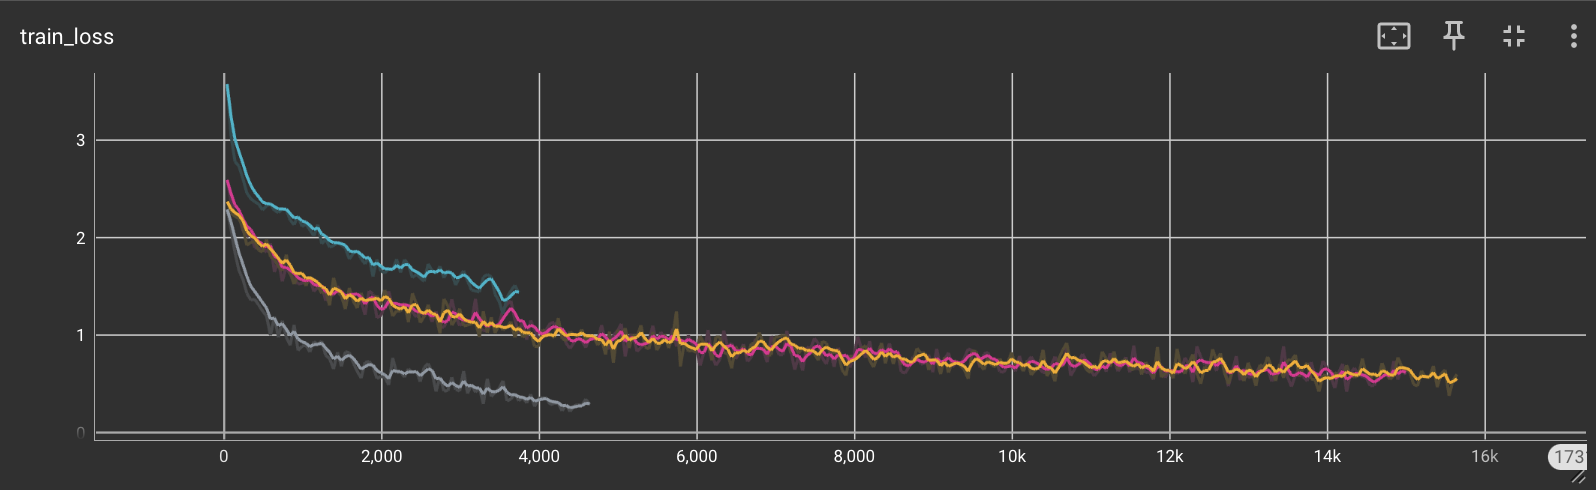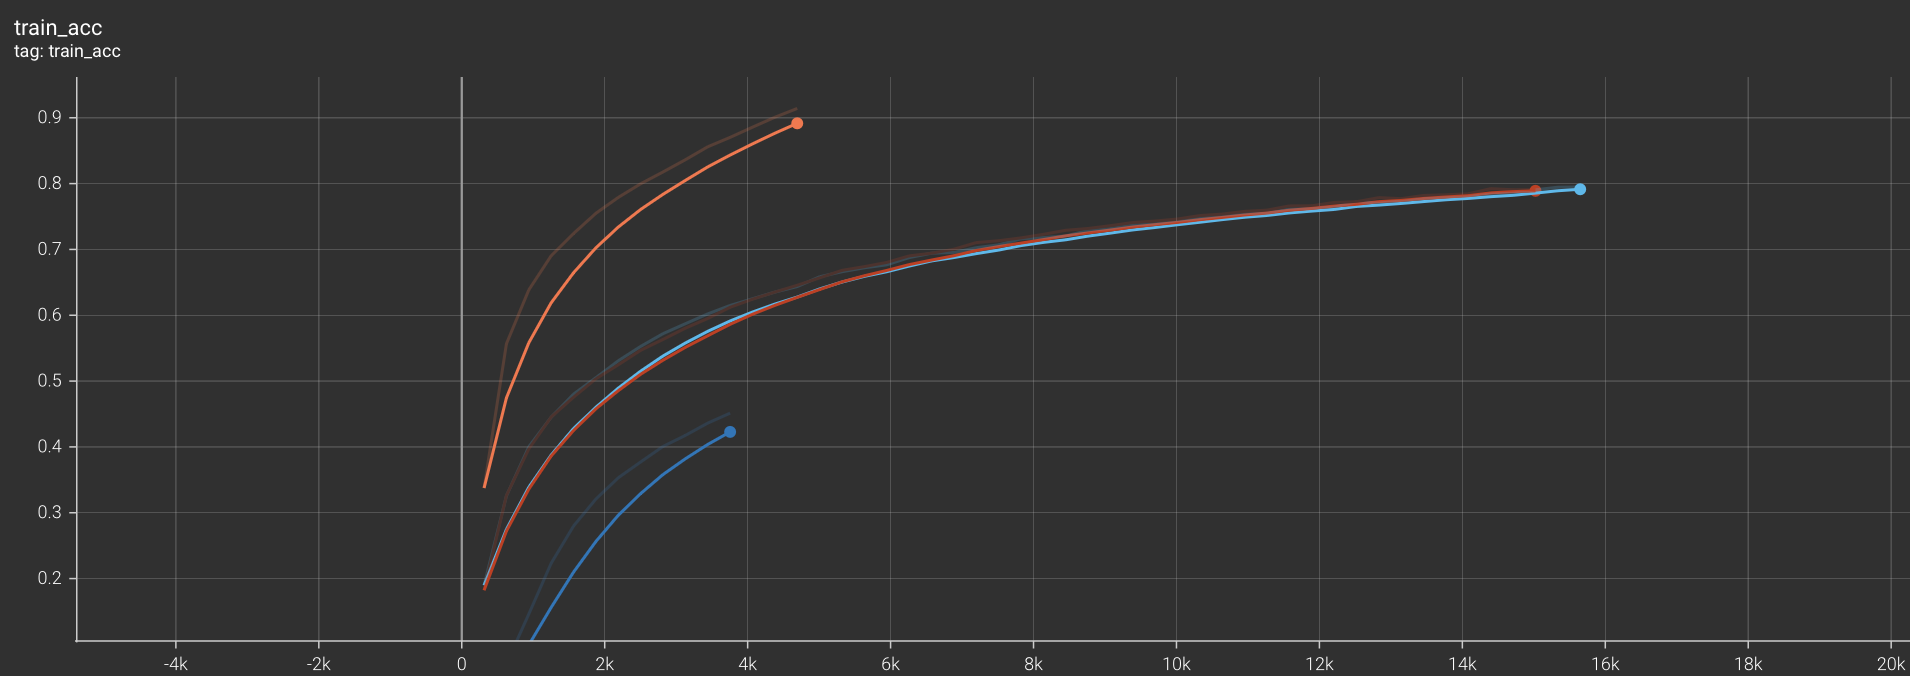

In the first two: val loss and train loss, Blue is adversarially trained, Orange/red is SAP, and gray is baseline


In the last graph (train acc), orange is baseline, red/lightblue is SAP, and blue is adv train

the train loss of the SAP and baseline is somewhat similar to the validation loss but as expected, the adversarially trained one has lower train loss than val loss due to the nature of the pgd attack. In addition, we see that the SAP model takes much longer to converge to an optimal val loss than the baseline model due to its complexity and stochasticity slowing its learning

### Bonus
Technically, because SAP is stochastic, the authors average the outputs of 100 runs. Try implementing this. How does the model's regular performance change? How does its performance against adversarial attacks change?

In [ ]:
class SAP_Conv2d(nn.Conv2d):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride=1,
            padding=0,
            groups=1,
            bias=True,
            dilation=1,
    ):
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, dilation, groups, bias)


    def _conv_forward(self, input, weight, bias):
        act = super()._conv_forward(input, weight, bias)

        # Initialize a tensor to accumulate SAP-modified activations
        sap_accumulated = torch.zeros_like(act)

        sap_iterations = 100
        for _ in range(sap_iterations):
            sap_modified = sap(act)  # Apply SAP to the activations
            sap_accumulated += sap_modified

        # Average the accumulated SAP-modified activations
        sap_averaged = sap_accumulated / sap_iterations
        print(sap_averaged)
        return sap_averaged


In [ ]:
# YOUR CODE HERE
for attack_method in ['id', 'fgsm', 'pgd']:
    print(f"Running experiment SAP with attack {attack_method}...")
    mb = 0
    # I've found 100 batches about matches the time of the other attacks' experiments
    if attack_method == 'pgd':
        mb = 100
    run_experiment('SAP_conv', attack_method, max_batches=mb)

Running experiment SAP with attack id...
Running experiment SAP with attack fgsm...
Running experiment SAP with attack pgd...


In [ ]:
for attack_method in ['id', 'fgsm', 'pgd']:
    print(f"Running experiment SAP with attack {attack_method}...")
    mb = 0
    # I've found 100 batches about matches the time of the other attacks' experiments
    if attack_method == 'pgd':
        mb = 100
    run_experiment('SAP_conv', attack_method, top_k=1, max_batches=mb)

Running experiment SAP with attack id...
Running experiment SAP with attack fgsm...
Running experiment SAP with attack pgd...


In [ ]:
df_results = pd.DataFrame(results_dic)
df_results

,model,attack,top_k,accuracy
0,baseline,id,1,0.7383
1,baseline,fgsm,1,0.3053
2,baseline,pgd,1,0.0823
3,adv_train,id,1,0.3044
4,adv_train,fgsm,1,0.5386
5,adv_train,pgd,1,0.3993
6,baseline,id,2,0.8855
7,baseline,fgsm,2,0.4805
8,baseline,pgd,2,0.2726
9,adv_train,id,2,0.4827


#### Expectations

Baseline Resnet: Expected to perform well under no attack (id) but to have significantly reduced accuracy under adversarial attacks (FGSM, PGD), due to its lack of adversarial training or defenses.

Adversarially Trained Resnet: Expected to show improved robustness against adversarial attacks compared to the baseline, at the cost of some performance under normal conditions.

SAP Defended Resnet: Anticipated to demonstrate enhanced resilience to adversarial attacks, similar to the adversarially trained Resnet, but with potentially better performance under normal conditions due to its defensive mechanism.

#### Observations

Baseline Resnet's accuracy significantly drops from 73.83% (top-1) and 88.55% (top-2) under normal conditions to 30.53% and 48.05% under FGSM, and further down to 8.23% and 27.26% under PGD. This matches expectations, highlighting its vulnerability to adversarial attacks.

Adversarially Trained Resnet exhibits a drop in accuracy under normal conditions (30.44% top-1, 48.27% top-2) compared to the baseline, likely due to its focus on robustness over accuracy. However, it significantly outperforms the baseline under both attacks, achieving 53.86% and 74.22% under FGSM, and 39.93% and 62.46% under PGD for top-1 and top-2 accuracies, respectively. This improvement against attacks meets expectations.
SAP Defended Resnet shows the highest accuracy under normal conditions (78.38% top-1, 90.80% top-2), indicating superior performance without sacrificing robustness. Under FGSM and PGD attacks, it also demonstrates resilience, albeit not as robust as the adversarially trained model against these specific attacks, with top-1 accuracies of 33.03% and 15.47%, and top-2 accuracies of 51.03% and 36.90%, respectively.

#### Attacks

PGD is a more potent attack compared to FGSM, as evidenced by the lower accuracies across all models when subjected to PGD. This is expected since PGD is an iterative attack that can more precisely exploit model vulnerabilities.

#### Defenses

Raw Performance:

SAP Conv exhibits the best raw performance under normal conditions (id), followed by the baseline, and then the adversarially trained model. The adversarial training significantly compromises normal accuracy, likely due to its generalized nature aimed at improving robustness.

Performance Against Adversarial Examples:

Adversarially trained Resnet shows the best performance against both FGSM and PGD, highlighting its effectiveness as a robust defense mechanism against these types of attacks. SAP Conv, while more effective than the baseline, does not match the adversarially trained model's robustness against these attacks but offers a better balance between normal condition performance and defense.

Training Time:

Adversarially training a model generally requires more time due to the need to generate adversarial examples and retrain the model to defend against them. In contrast, SAP's impact on training time can vary depending on the implementation but is expected to be less than adversarially training from scratch since it's a post-processing step applied to an already trained model. However, specific training time data is not provided, making precise comparisons difficult.

#### Summary:

While adversarial training offers the best defense against FGSM and PGD attacks, it does so at the cost of raw performance under normal conditions. SAP Conv provides a promising balance between maintaining high accuracy under normal conditions and offering some level of defense against adversarial attacks. The choice between these defenses would depend on the specific requirements and constraints of the application, including the expected adversarial threat model and the importance of maintaining high accuracy under normal operating conditions.